**Introduction**

**Import Libraries**

In [1]:
import os
import glob
import torch
import numpy as np
import nibabel as nib

import matplotlib.pyplot as plt
%matplotlib inline

**Visualize Data**

In [52]:
data_dir = '/content/images'
images = sorted(
    glob.glob(os.path.join(data_dir, "sub*.nii.gz")))
labels = sorted(
    glob.glob(os.path.join(data_dir, "sub*.nii.gz")))

print('No. of images:', len(images), ' labels:', len(labels))

No. of images: 4  labels: 4


img shape: (176, 240, 256)  lbl shape: (176, 240, 256)
img intensity min.: 0.0  max.: 1094.0  unique labels: [0.000e+00 1.000e+00 2.000e+00 ... 1.069e+03 1.079e+03 1.094e+03]


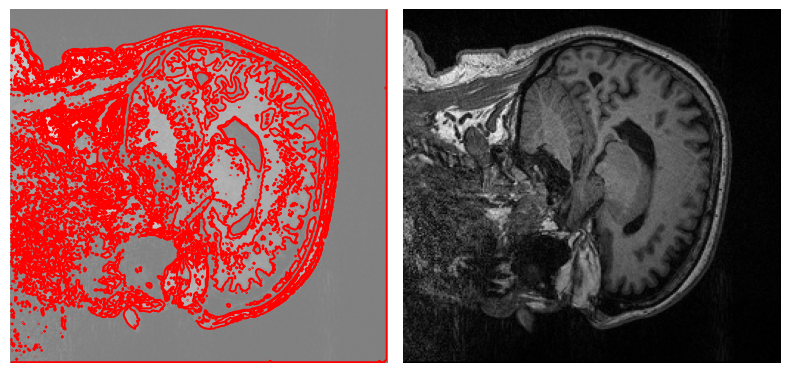

In [53]:
img = nib.load(images[0]).get_fdata()
lbl = nib.load(labels[0]).get_fdata()
print('img shape:', img.shape, ' lbl shape:', lbl.shape)
print('img intensity min.:', np.min(img), ' max.:', np.max(img), ' unique labels:', np.unique(lbl))

slice_idx = 100
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(img[slice_idx], cmap='gray', vmin=-1000, vmax=1000)
plt.contour(lbl[slice_idx], colors='red')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbl[slice_idx], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

**Set Determinism for Reproducibility of Results**

In [17]:
!pip install monai
from monai.utils import first, set_determinism

set_determinism(seed=0)

  Using cached monai-1.3.0-202310121228-py3-none-any.whl (1.3 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.wh

Next, we define a dict that includes image and label paths for each patient. As this dataset contains only 4 patients, we use 2, 1 and 1 patients for training, validation and testing respectively.

In [54]:
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(images, labels)
]

train_files, val_files, test_files = data_dicts[:2], data_dicts[2:3], data_dicts[-1:]

print('train files:', len(train_files), ' val files:', len(val_files), ' test files:', len(test_files))


train files: 2  val files: 1  test files: 1


**Define Transforms for Preprocessing**

In [55]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandAffined,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),

        # Change labels from 255 to 1
        ScaleIntensityRanged(
            keys=["label"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),

        # Randomly crop a patch from both image and label files
        RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[96, 96, 96],
                random_size=False,
        ),

        # Data augmentation transforms
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 96),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=2),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ])

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        ScaleIntensityRanged(
            keys=["label"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ])

In [22]:
!pip install 'monai[all]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 35.8 MB/s 

We can now visualize a sample patch from our training dataset.

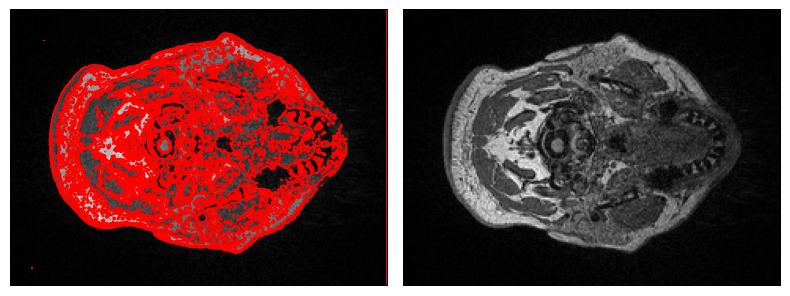

In [58]:
sample_ds = Dataset(data=train_files, transform=train_transforms)
sample_dataloader = DataLoader(sample_ds, batch_size=1)

sample_batch = sample_dataloader

# img, lbl = sample_batch["image"][0][0], sample_batch["label"][0][0]
# print(f"img shape: {img.shape}, lbl shape: {lbl.shape}")

slice_idx = 64
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(img[:,:,slice_idx], cmap='gray')
plt.contour(lbl[:,:,slice_idx], colors='red')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbl[:,:,slice_idx], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()
print(sample_batch)

In [59]:
# Check if the train_files and val_files variables contain valid file paths.
print(train_files)
print(val_files)

# Check if the train_transforms and val_transforms variables contain valid transforms.
print(train_transforms)
print(val_transforms)

[{'image': '/content/images/sub-OAS31469_sess-d0105_T1w.nii.gz', 'label': '/content/images/sub-OAS31469_sess-d0105_T1w.nii.gz'}, {'image': '/content/images/sub-OAS31470_sess-d0007_T1w.nii.gz', 'label': '/content/images/sub-OAS31470_sess-d0007_T1w.nii.gz'}]
[{'image': '/content/images/sub-OAS31473_sess-d0136_T1w.nii.gz', 'label': '/content/images/sub-OAS31473_sess-d0136_T1w.nii.gz'}]


In [60]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
val_loader = DataLoader(val_ds, batch_size=1)

Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


**Define Model, Loss Function and Optimizer**

This code defines and initializes the main components for training a 3D segmentation model using the MONAI library. The model is defined as an instance of the U-Net class, which is a popular architecture for image segmentation tasks. The loss function is DiceLoss, the optimizer is Adam, and the evaluation metric is DiceMetric. These components are essential for training and evaluating the performance of the model.

In [61]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm

device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [64]:
from monai.inferers import sliding_window_inference

# Define hyperparameters
max_epochs = 500
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# Define post-processing transforms
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# Training loop
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in sample_dataloader:
        step += 1
        inputs, labels = batch_data["image"], batch_data["label"]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"], val_data["label"],
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 1, model)

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/500
1/1, train_loss: 0.4729
2/1, train_loss: 0.5258
epoch 1 average loss: 0.4993
----------
epoch 2/500
1/1, train_loss: 0.4705
2/1, train_loss: 0.4517
epoch 2 average loss: 0.4611
saved new best metric model
current epoch: 2 current mean dice: 0.2372
best mean dice: 0.2372 at epoch: 2
----------
epoch 3/500
1/1, train_loss: 0.4656
2/1, train_loss: 0.4512
epoch 3 average loss: 0.4584
----------
epoch 4/500
1/1, train_loss: 0.4569
2/1, train_loss: 0.4153
epoch 4 average loss: 0.4361
saved new best metric model
current epoch: 4 current mean dice: 0.2384
best mean dice: 0.2384 at epoch: 4
----------
epoch 5/500
1/1, train_loss: 0.4291
2/1, train_loss: 0.4304
epoch 5 average loss: 0.4298
----------
epoch 6/500
1/1, train_loss: 0.4211
2/1, train_loss: 0.4307
epoch 6 average loss: 0.4259
saved new best metric model
current epoch: 6 current mean dice: 0.2859
best mean dice: 0.2859 at epoch: 6
----------
epoch 7/500
1/1, train_loss: 0.4652
2/1, train_loss: 0.4090
epoch 7 ave

In [65]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8346 at epoch: 456


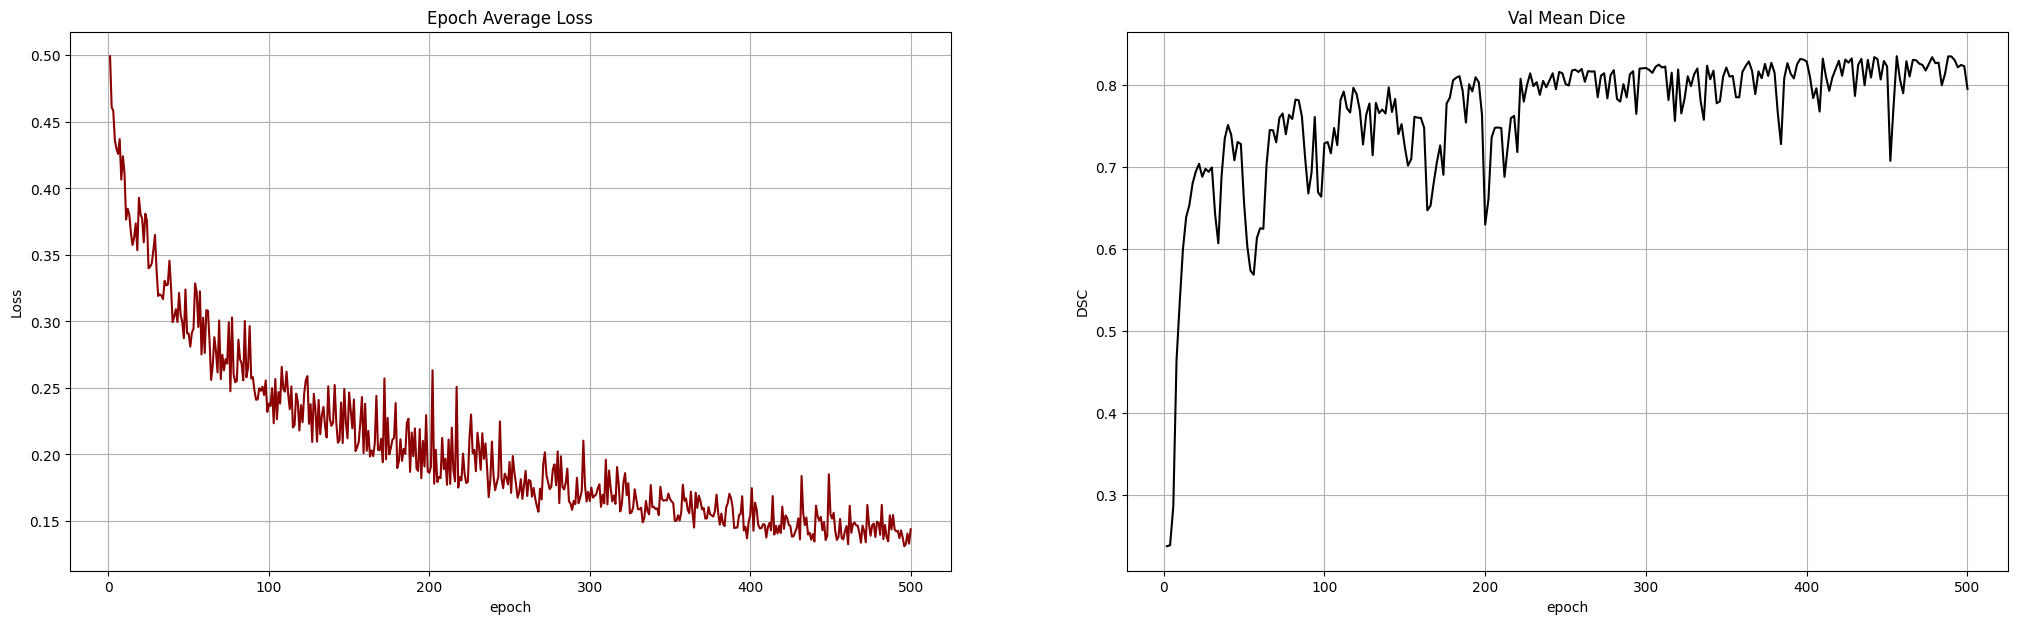

In [66]:
plt.figure("train", (25,7))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.plot(x, y, color='darkred')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.ylabel("DSC")
plt.xlabel("epoch")
plt.grid(True)
plt.plot(x, y, color='black')
plt.show()